### Clothes

In [1]:
import ast
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict, Counter
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex
from tqdm import tqdm

In [2]:
dataset_name = "Clothes"
dataset_dir = "/data/common/RecommendationDatasets/{dataset_name}_Amazon14/topics/".format(dataset_name=dataset_name)

topics = [
    "appearance",
    "care",
    "comfort",
    "construction",
    "functionality",
    "fit",
    "material",
    "price",
    "service",
    "shipping"
]
sentiments = [
    "positive",
    "negative",
    "neutral"
]

topics.sort()
print(topics)
with open(os.path.join(dataset_dir, "topics.json"), "w") as f:
    json.dump(topics, f)

['appearance', 'care', 'comfort', 'construction', 'fit', 'functionality', 'material', 'price', 'service', 'shipping']


In [3]:
data_df = pd.read_csv(os.path.join(dataset_dir, "statement.csv"))
data_df.head()

,helpful,reviewTime,rating,timestamp,review,user_name,user_id,item_id,review_title,statements
0,"[0, 0]","02 12, 2011",5.0,1297468800,This is a great tutu and at a really great pri...,"Amazon Customer ""cameramom""",A1KLRMWW2FWPL4,0000031887,Great tutu- not cheaply made,[{'statement': 'has a low price relative to ex...
1,"[0, 0]","01 19, 2013",5.0,1358553600,I bought this for my 4 yr old daughter for dan...,Amazon Customer,A2G5TCU2WDFZ65,0000031887,Very Cute!!,[{'statement': 'is suitable for 4-year-old chi...
2,"[0, 0]","01 4, 2013",5.0,1357257600,What can I say... my daughters have it in oran...,Carola,A1RLQXYNCMWRWN,0000031887,I have buy more than one,"[{'statement': 'comes in multiple colors', 'to..."
3,"[0, 0]","04 27, 2014",5.0,1398556800,"We bought several tutus at once, and they are ...",Caromcg,A8U3FAMSJVHS5,0000031887,"Adorable, Sturdy","[{'statement': 'has high reviews', 'topic': 's..."
4,"[0, 0]","03 15, 2014",5.0,1394841600,Thank you Halo Heaven great product for Little...,CJ,A3GEOILWLK86XM,0000031887,Grammy's Angels Love it,"[{'statement': 'is well-made', 'topic': 'const..."


In [4]:
statement_triplets = data_df["statements"].tolist()
print(statement_triplets[0:5])

["[{'statement': 'has a low price relative to expectations', 'topic': 'price', 'sentiment': 'positive'}, {'statement': 'does not look cheap', 'topic': 'appearance', 'sentiment': 'positive'}, {'statement': 'is not poorly made', 'topic': 'construction', 'sentiment': 'positive'}]", "[{'statement': 'is suitable for 4-year-old children', 'topic': 'fit', 'sentiment': 'neutral'}, {'statement': 'is considered adorable by a teacher', 'topic': 'appearance', 'sentiment': 'positive'}, {'statement': 'matches color of a light blue long sleeve leotard', 'topic': 'appearance', 'sentiment': 'positive'}, {'statement': 'has a competitive price compared to similar products', 'topic': 'price', 'sentiment': 'positive'}]", "[{'statement': 'comes in multiple colors', 'topic': 'appearance', 'sentiment': 'positive'}, {'statement': 'is comfortable to wear', 'topic': 'comfort', 'sentiment': 'positive'}, {'statement': 'looks great', 'topic': 'appearance', 'sentiment': 'positive'}, {'statement': 'is easy to wear', 

In [5]:
i = 0
for triplet_list in statement_triplets:
    triplet_list = ast.literal_eval(triplet_list)
    for triplet in triplet_list:
        statement = triplet.get("statement").lower().strip()
        topic = triplet.get("topic").lower().strip()
        sentiment = triplet.get("sentiment").lower().strip()

        print(statement.center(60), topic.center(20), sentiment.center(10), sep="|\t\t\t")
        i += 1

    if i > 40:
        break

          has a low price relative to expectations          |			       price        |			 positive 
                    does not look cheap                     |			     appearance     |			 positive 
                     is not poorly made                     |			    construction    |			 positive 
            is suitable for 4-year-old children             |			        fit         |			 neutral  
            is considered adorable by a teacher             |			     appearance     |			 positive 
     matches color of a light blue long sleeve leotard      |			     appearance     |			 positive 
    has a competitive price compared to similar products    |			       price        |			 positive 
                  comes in multiple colors                  |			     appearance     |			 positive 
                   is comfortable to wear                   |			      comfort       |			 positive 
                        looks great                         |			     appearance     |			 positive 
          

In [6]:
def process_triplets(statement_triplets, topics, sentiments):
    correct_triplets = {}
    wrong_topics = {}
    wrong_sentiments = {}
    wrong_topics_and_sentiments = {}
    
    for triplet_list in statement_triplets:
        if not triplet_list: continue
        if type(triplet_list) != list:
            try:
                triplet_list = ast.literal_eval(triplet_list)
            except:
                continue
    
        for triplet in triplet_list:
            if not triplet: continue

            accepted_topic = True
            accepted_sentiment = True
                
            topic = triplet.get("topic")
            if topic: topic = topic.lower().replace("-", " ").replace("_", " ").strip()
            else: continue
            if topic not in topics: accepted_topic = False

            sentiment = triplet.get("sentiment")
            if sentiment: sentiment = sentiment.lower().strip()
            else: continue
            if sentiment not in sentiments: accepted_sentiment = False
        
            statement = triplet.get("statement")
            if statement: statement = statement.lower().replace("-", " ").replace("_", " ").strip()
            else: continue
            
            if not (accepted_topic or accepted_sentiment):
                if topic not in wrong_topics_and_sentiments:
                    wrong_topics_and_sentiments[topic] = {}
                if sentiment not in wrong_topics_and_sentiments[topic]:
                    wrong_topics_and_sentiments[topic][sentiment] = {}
                if statement not in wrong_topics_and_sentiments[topic][sentiment]:
                    wrong_topics_and_sentiments[topic][sentiment][statement] = 0
                wrong_topics_and_sentiments[topic][sentiment][statement] += 1

            elif accepted_sentiment and not accepted_topic:
                if topic not in wrong_topics:
                    wrong_topics[topic] = {}
                if sentiment not in wrong_topics[topic]:
                    wrong_topics[topic][sentiment] = {}
                if statement not in wrong_topics[topic][sentiment]:
                    wrong_topics[topic][sentiment][statement] = 0
                wrong_topics[topic][sentiment][statement] += 1

            elif accepted_topic and not accepted_sentiment:
                if topic not in wrong_sentiments:
                    wrong_sentiments[topic] = {}
                if sentiment not in wrong_sentiments[topic]:
                    wrong_sentiments[topic][sentiment] = {}
                if statement not in wrong_sentiments[topic][sentiment]:
                    wrong_sentiments[topic][sentiment][statement] = 0
                wrong_sentiments[topic][sentiment][statement] += 1      

            else:
                if topic not in correct_triplets:
                    correct_triplets[topic] = {}
                if sentiment not in correct_triplets[topic]:
                    correct_triplets[topic][sentiment] = {}
                if statement not in correct_triplets[topic][sentiment]:
                    correct_triplets[topic][sentiment][statement] = 0
                correct_triplets[topic][sentiment][statement] += 1    
                
    return correct_triplets, wrong_topics, wrong_sentiments, wrong_topics_and_sentiments

In [7]:
correct_triplets, wrong_topics, wrong_sentiments, wrong_topics_and_sentiments = process_triplets(
    statement_triplets, topics, sentiments
)

In [8]:
len(correct_triplets), len(wrong_topics), len(wrong_sentiments), len(wrong_topics_and_sentiments)

(10, 156, 4, 1)

In [9]:
def build_topic_stats_df(topics):
    all_topics = sorted(topics.keys())
    all_sentiments = sorted({s for t in topics.values() for s in t.keys()})
    rows = []
    for topic in all_topics:
        row = {}
        uniq_total = 0
        freq_total = 0
        for s in all_sentiments:
            counts = topics[topic].get(s, {})
            u = len(counts)
            f = int(sum(counts.values())) if counts else 0
            row[(s, "unique")] = u
            row[(s, "total")] = f
            uniq_total += u
            freq_total += f
        row[("TOTAL", "unique")] = uniq_total
        row[("TOTAL", "total")] = freq_total
        rows.append(row)
    cols = []
    for s in all_sentiments:
        cols.append((s, "unique"))
        cols.append((s, "total"))
    cols.extend([("TOTAL", "unique"), ("TOTAL", "total")])
    df = pd.DataFrame(rows, index=all_topics, columns=pd.MultiIndex.from_tuples(cols))
    df = df.fillna(0).astype(int)
    return df

In [10]:
correct_triplets_df_stats = build_topic_stats_df(correct_triplets)
print(correct_triplets_df_stats)

              negative         neutral        positive           TOTAL        
                unique   total  unique  total   unique   total  unique   total
appearance       19273   26988   10310  12251    62575  153030   92158  192269
care              6262    7645    5588   6429     9408   17864   21258   31938
comfort          18423   25253    4636   5625    44529  130134   67588  161012
construction     28632   35486    6638   7327    25351   57713   60621  100526
fit              59483  100116   35525  45372    67915  141357  162923  286845
functionality    21441   24315   14137  15163    96933  143768  132511  183246
material         19044   28719   11904  15966    33158   82619   64106  127304
price             6596   11888    4046   5300    16909   57990   27551   75178
service           4992    6634    2239   2466    10679   19152   17910   28252
shipping          3598    4832    2693   3211     5630   18952   11921   26995


In [11]:
correct_triplets_df_stats.sum(axis=0)

negative  unique     187744
          total      271876
neutral   unique      97716
          total      119110
positive  unique     373087
          total      822579
TOTAL     unique     658547
          total     1213565
dtype: int64

In [12]:
wrong_sentiments

{'comfort': {'mixed': {'is comfortable except for a specific issue': 1,
   'are comfortable except for toe touch': 1}},
 'functionality': {'suggestion': {'have zip off pant legs': 1}},
 'service': {'cautionary': {'require caution': 1}},
 'care': {'unknown': {'has not shrunk after washing': 1}}}

In [13]:
wrong_topics_df_stats = build_topic_stats_df(wrong_topics)
print(wrong_topics_df_stats)

                negative       neutral       positive        TOTAL      
                  unique total  unique total   unique total unique total
accessories            1     1       0     0        1     1      2     2
accuracy               8     8       9     9        8     8     25    25
assortment             0     0       0     0        1     1      1     1
authenticity           0     0       0     0        3     3      3     3
availability         151   173     106   115       53    56    310   344
...                  ...   ...     ...   ...      ...   ...    ...   ...
wear                   0     0       2     2        0     0      2     2
wear and tear          1     1       0     0        0     0      1     1
weather                1     1       2     2        1     1      4     4
weight                76   129      81   124      106   171    263   424
wind resistance        0     0       0     0        1     1      1     1

[156 rows x 8 columns]


In [14]:
wrong_topics_df_stats.sum(axis=0)

negative  unique     766
          total      903
neutral   unique     726
          total      806
positive  unique    1905
          total     2326
TOTAL     unique    3397
          total     4035
dtype: int64

In [15]:
(wrong_topics_df_stats.sum(axis=0) / (wrong_topics_df_stats.sum(axis=0) + correct_triplets_df_stats.sum(axis=0))) * 100

negative  unique    0.406344
          total     0.331037
neutral   unique    0.737490
          total     0.672137
positive  unique    0.508011
          total     0.281972
TOTAL     unique    0.513185
          total     0.331390
dtype: float64

In [16]:
wrong_topics_stats = wrong_topics_df_stats["TOTAL"]["unique"].to_dict()
print(wrong_topics_stats)

{'accessories': 2, 'accuracy': 25, 'assortment': 1, 'authenticity': 3, 'availability': 310, 'battery': 3, 'battery life': 1, 'brand': 238, 'brand loyalty': 12, 'brand preference': 2, 'brand reputation': 18, 'breathability': 3, 'capacity': 3, 'cold resistance': 1, 'collection': 1, 'color': 59, 'color accuracy': 32, 'color options': 1, 'color retention': 2, 'colorfastness': 7, 'comparison': 16, 'compatibility': 1, 'concept': 1, 'condition': 3, 'culture': 1, 'description': 5, 'design': 7, 'desire': 3, 'display': 1, 'durability': 492, 'ecodrive': 1, 'emotional value': 1, 'experience': 5, 'eyelash skirt': 1, 'fragrance': 1, 'frequency': 3, 'frequency of use': 2, 'frequency of wear': 1, 'freshness': 1, 'general': 150, 'general opinion': 2, 'general quality': 1, 'gift giving': 1, 'health': 14, 'height': 2, 'history': 8, 'identification': 1, 'information': 8, 'inseam': 4, 'insoles': 1, 'insulation': 3, 'inventory': 1, 'label': 1, 'labeling': 3, 'labor practices': 3, 'language': 1, 'length': 16

In [17]:
# try to assign correct topic if possible
for topic in wrong_topics:
    print(topic)
    for sent in wrong_topics[topic]:
        statements = wrong_topics[topic][sent]
        statements = list(dict(sorted(statements.items(), key=lambda x: x[1])))
        if len(statements) > 4:
            statements = statements[:4]
        print("\t", sent, ":", "\n\t\t".join(statements))

durability
	 negative : may not withstand heavy use
		would not last more than 6 months for construction work
		only gets a few wears
		has a limited lifespan
	 neutral : will probably last as long as his attention
		may not last long
		gets about 1 year out of a pair
		are expected to last one night
	 positive : are worn until they are in poor condition
		expect to need a new pair soon due to frequent wear
		can be worn for a year or more
		lasts for a year with heavy use
language
	 neutral : no english spoken, only italian
size
	 positive : is small and lightweight
		are small enough to wear to work
		is small and easy to carry
		is smaller than most ditty bags
	 negative : is very small
		is large
		is not big enough for all products
		is too big for personal use
	 neutral : comes in size 32x31
		is available in kids' size 1
		is very big
		bag is large
weight
	 positive : is not as heavy as other coats
		strap is not heavy
		remains under weight limit
		is heavy, in a positive way


**Prompt** : ```The extraction of triplets (atomic statement, topic, sentiment) from reviews produced topics that are not in the accepted topics list (represented by their short name). I will give you the list of incorrect topics, with a few example statements per sentiment. Analyze the statements and estimate the closest accepted topic it can be assigned to. If no statement is provided, do not assign anything; and if an assignment is impossible, do not assign one either. Here are the examples [EXAMPLES]. Here is the list of accepted topics for the Amazon Clothes dataset:
ACCEPTED TOPICS (short name (long name): description) [TOPICS]
You must output a JSON object; keys are the incorrect topics and their values are the short name of the accepted topic they’re assigned to. Use None for incorrect topics that are not assigned.```

In [18]:
gpt_assignation = {
    "durability": "construction",
    "language": None,
    "size": "fit",
    "weight": "comfort",
    "usage": None,
    "availability": None,
    "overall": None,
    "brand reputation": None,
    "brand": None,
    "history": None,
    "recommendation": None,
    "frequency": None,
    "quantity": None,
    "color accuracy": "appearance",
    "none": None,
    "color": "appearance",
    "shopping": None,
    "water resistance": "functionality",
    "manufacturing": None,
    "temperature": "functionality",
    "general": None,
    "value": "price",
    "sound": None,
    "overall quality": None,
    "quality": None,
    "colorfastness": "care",
    "accuracy": "functionality",
    "desire": None,
    "packaging": "shipping",
    "length": "fit",
    "production location": None,
    "waterproofing": "functionality",
    "labeling": None,
    "product": None,
    "manufacturing location": None,
    "wear": None,
    "color retention": "care",
    "style": "appearance",
    "name": None,
    "product lifecycle": None,
    "lume": "functionality",
    "gift giving": None,
    "overall impression": None,
    "brand loyalty": None,
    "waterproof": "functionality",
    "waterproofness": "functionality",
    "noise": None,
    "warmth": "functionality",
    "temperature regulation": "functionality",
    "authenticity": None,
    "visibility": "functionality",
    "accessories": "functionality",
    "comparison": None,
    "product overall": None,
    "product line": None,
    "health": "comfort",
    "size and portability": "functionality",
    "concept": None,
    "security": "functionality",
    "target audience": None,
    "inventory": None,
    "stability": "functionality",
    "warranty": "service",
    "design": "functionality",
    "unknown": None,
    "description": "service",
    "purchase": None,
    "self perception": None,
    "occasion": None,
    "personal preference": None,
    "pain": "comfort",
    "water exposure": "functionality",
    "identification": None,
    "general opinion": None,
    "insoles": "construction",
    "longevity": "construction",
    "temperature tolerance": "functionality",
    "luxury lane products": None,
    "condition": "shipping",
    "product name": None,
    "insulation": "functionality",
    "cold resistance": "functionality",
    "slipperiness": "functionality",
    "culture": None,
    "information": None,
    "reliability": "construction",
    "wear and tear": "construction",
    "location": None,
    "purchase intention": None,
    "marketing": None,
    "capacity": "functionality",
    "collection": None,
    "meaningfulness": None,
    "ecodrive": "functionality",
    "timekeeping": "functionality",
    "organization": "functionality",
    "battery life": "functionality",
    "portability": "functionality",
    "seller": None,
    "sentiment": None,
    "seasonal usage": "functionality",
    "breathability": "comfort",
    "safety": "functionality",
    "seasonality": "functionality",
    "shopping experience": None,
    "experience": None,
    "eyelash skirt": None,
    "weather": "functionality",
    "light": "functionality",
    "returns": "service",
    "frequency of use": None,
    "order": None,
    "memory": None,
    "height": "fit",
    "assortment": None,
    "label": None,
    "return": "service",
    "temperature suitability": "functionality",
    "freshness": None,
    "labor practices": None,
    "inseam": "fit",
    "traction": "functionality",
    "brand preference": None,
    "subjective": None,
    "purpose": None,
    "product quality": None,
    "water repellency": "functionality",
    "uniqueness": "appearance",
    "social impact": None,
    "emotional value": None,
    "frequency of wear": None,
    "thickness": "material",
    "seasonal suitability": "functionality",
    "origin": None,
    "general quality": None,
    "popularity": None,
    "display": "functionality",
    "battery": "functionality",
    "temperature retention": "functionality",
    "wind resistance": "functionality",
    "support": "comfort",
    "waist": "fit",
    "sleeves": "appearance",
    "topic": None,
    "personality": None,
    "ownership": None,
    "overall satisfaction": None,
    "pity": None,
    "production": None,
    "research": None,
    "sleeve length": "fit",
    "purchase quantity": None,
    "fragrance": None,
    "color options": "appearance",
    "product knowledge": None,
    "compatibility": "functionality"
}

In [19]:
claude_assignation = {
  "durability": "construction",
  "language": None,
  "size": "fit",
  "weight": "material",
  "usage": None,
  "availability": None,
  "overall": None,
  "brand reputation": None,
  "brand": None,
  "history": None,
  "recommendation": None,
  "frequency": None,
  "quantity": None,
  "color accuracy": "appearance",
  "none": None,
  "color": "appearance",
  "shopping": None,
  "water resistance": "functionality",
  "manufacturing": None,
  "temperature": "functionality",
  "general": None,
  "value": "price",
  "sound": None,
  "overall quality": None,
  "quality": None,
  "colorfastness": "care",
  "accuracy": None,
  "desire": None,
  "packaging": "shipping",
  "length": "fit",
  "production location": None,
  "waterproofing": "functionality",
  "labeling": None,
  "product": None,
  "manufacturing location": None,
  "wear": None,
  "color retention": "care",
  "style": "appearance",
  "name": None,
  "product lifecycle": None,
  "lume": None,
  "gift giving": None,
  "overall impression": None,
  "brand loyalty": None,
  "waterproof": "functionality",
  "waterproofness": "functionality",
  "noise": None,
  "warmth": "functionality",
  "temperature regulation": "functionality",
  "authenticity": None,
  "visibility": None,
  "accessories": None,
  "comparison": None,
  "product overall": None,
  "product line": None,
  "health": None,
  "size and portability": "fit",
  "concept": None,
  "security": "functionality",
  "target audience": None,
  "inventory": None,
  "stability": None,
  "warranty": None,
  "design": "appearance",
  "unknown": None,
  "description": None,
  "purchase": None,
  "self perception": None,
  "occasion": None,
  "personal preference": None,
  "pain": "comfort",
  "water exposure": None,
  "identification": None,
  "general opinion": None,
  "insoles": "comfort",
  "longevity": "construction",
  "temperature tolerance": "functionality",
  "luxury lane products": None,
  "condition": None,
  "product name": None,
  "insulation": "functionality",
  "cold resistance": "functionality",
  "slipperiness": None,
  "culture": None,
  "information": None,
  "reliability": "construction",
  "wear and tear": "construction",
  "location": None,
  "purchase intention": None,
  "marketing": None,
  "capacity": "functionality",
  "collection": None,
  "meaningfulness": None,
  "ecodrive": None,
  "timekeeping": None,
  "organization": None,
  "battery life": None,
  "portability": "functionality",
  "seller": "service",
  "sentiment": None,
  "seasonal usage": "functionality",
  "breathability": "comfort",
  "safety": None,
  "seasonality": "functionality",
  "shopping experience": None,
  "experience": None,
  "eyelash skirt": None,
  "weather": "functionality",
  "light": None,
  "returns": "service",
  "frequency of use": None,
  "order": None,
  "memory": None,
  "height": "fit",
  "assortment": None,
  "label": None,
  "return": "service",
  "temperature suitability": "functionality",
  "freshness": None,
  "labor practices": None,
  "inseam": "fit",
  "traction": "functionality",
  "brand preference": None,
  "subjective": None,
  "purpose": None,
  "product quality": None,
  "water repellency": "functionality",
  "uniqueness": None,
  "social impact": None,
  "emotional value": None,
  "frequency of wear": None,
  "thickness": "material",
  "seasonal suitability": "functionality",
  "origin": None,
  "general quality": None,
  "popularity": None,
  "display": None,
  "battery": None,
  "temperature retention": "functionality",
  "wind resistance": "functionality",
  "support": "comfort",
  "waist": "fit",
  "sleeves": "fit",
  "topic": None,
  "personality": None,
  "ownership": None,
  "overall satisfaction": None,
  "pity": None,
  "production": None,
  "research": None,
  "sleeve length": "fit",
  "purchase quantity": None,
  "fragrance": None,
  "color options": "appearance",
  "product knowledge": None,
  "compatibility": "functionality"
}

In [20]:
gemini_assignation = {
  "durability": "construction",
  "language": None,
  "size": "fit",
  "weight": "material",
  "usage": None,
  "availability": None,
  "overall": None,
  "brand reputation": None,
  "brand": None,
  "history": None,
  "recommendation": None,
  "frequency": None,
  "quantity": None,
  "color accuracy": "appearance",
  "none": None,
  "color": "appearance",
  "shopping": None,
  "water resistance": "functionality",
  "manufacturing": None,
  "temperature": "functionality",
  "general": None,
  "value": "price",
  "sound": None,
  "overall quality": "construction",
  "quality": "construction",
  "colorfastness": "care",
  "accuracy": None,
  "desire": None,
  "packaging": "shipping",
  "length": "fit",
  "production location": None,
  "waterproofing": "functionality",
  "labeling": None,
  "product": None,
  "manufacturing location": None,
  "wear": None,
  "color retention": "care",
  "style": "appearance",
  "name": None,
  "product lifecycle": None,
  "lume": None,
  "gift giving": None,
  "overall impression": None,
  "brand loyalty": None,
  "waterproof": "functionality",
  "waterproofness": "functionality",
  "noise": None,
  "warmth": "functionality",
  "temperature regulation": "functionality",
  "authenticity": None,
  "visibility": "functionality",
  "accessories": None,
  "comparison": None,
  "product overall": None,
  "product line": None,
  "health": None,
  "size and portability": "fit",
  "concept": None,
  "security": "functionality",
  "target audience": None,
  "inventory": None,
  "stability": "construction",
  "warranty": "service",
  "design": None,
  "unknown": None,
  "description": None,
  "purchase": None,
  "self perception": None,
  "occasion": None,
  "personal preference": None,
  "pain": None,
  "water exposure": None,
  "identification": None,
  "general opinion": None,
  "insoles": "construction",
  "longevity": "construction",
  "temperature tolerance": "functionality",
  "luxury lane products": None,
  "condition": None,
  "product name": None,
  "insulation": "functionality",
  "cold resistance": "functionality",
  "slipperiness": "functionality",
  "culture": None,
  "information": None,
  "reliability": "construction",
  "wear and tear": "construction",
  "location": None,
  "purchase intention": None,
  "marketing": None,
  "capacity": "functionality",
  "collection": None,
  "meaningfulness": None,
  "ecodrive": "functionality",
  "timekeeping": "functionality",
  "organization": "functionality",
  "battery life": "functionality",
  "portability": "fit",
  "seller": None,
  "sentiment": None,
  "seasonal usage": "functionality",
  "breathability": "comfort",
  "safety": "construction",
  "seasonality": "functionality",
  "shopping experience": None,
  "experience": None,
  "eyelash skirt": None,
  "weather": "functionality",
  "light": "functionality",
  "returns": "service",
  "frequency of use": None,
  "order": None,
  "memory": None,
  "height": "fit",
  "assortment": None,
  "label": None,
  "return": "service",
  "temperature suitability": "functionality",
  "freshness": None,
  "labor practices": None,
  "inseam": "fit",
  "traction": "functionality",
  "brand preference": None,
  "subjective": None,
  "purpose": None,
  "product quality": "construction",
  "water repellency": "functionality",
  "uniqueness": None,
  "social impact": None,
  "emotional value": None,
  "frequency of wear": None,
  "thickness": "material",
  "seasonal suitability": "functionality",
  "origin": None,
  "general quality": "construction",
  "popularity": None,
  "display": "functionality",
  "battery": "functionality",
  "temperature retention": "functionality",
  "wind resistance": "functionality",
  "support": "construction",
  "waist": "fit",
  "sleeves": "fit",
  "topic": None,
  "personality": None,
  "ownership": None,
  "overall satisfaction": None,
  "pity": None,
  "production": None,
  "research": None,
  "sleeve length": "fit",
  "purchase quantity": None,
  "fragrance": None,
  "color options": "appearance",
  "product knowledge": None,
  "compatibility": "functionality"
}

In [21]:
remain_wrong_topics = [t for t, n_st in wrong_topics_stats.items() if n_st >= 10]
print(remain_wrong_topics)
print(len(remain_wrong_topics))

['accuracy', 'availability', 'brand', 'brand loyalty', 'brand reputation', 'color', 'color accuracy', 'comparison', 'durability', 'general', 'health', 'length', 'none', 'overall', 'overall quality', 'packaging', 'product', 'purchase', 'quality', 'quantity', 'recommendation', 'shopping', 'size', 'sound', 'style', 'temperature', 'unknown', 'usage', 'value', 'water resistance', 'waterproof', 'waterproofing', 'weight']
33


In [22]:
final_assignation = {}
for topic in wrong_topics:
    assignations = [
        gpt_assignation.get(topic, None),
        claude_assignation.get(topic, None),
        gemini_assignation.get(topic, None)
    ]
    value_set = set(assignations)
    for value in value_set:
        if value is None: continue
        if assignations.count(value) == 3:
            final_assignation[topic] = value

In [23]:
final_assignation

{'durability': 'construction',
 'size': 'fit',
 'color accuracy': 'appearance',
 'color': 'appearance',
 'water resistance': 'functionality',
 'temperature': 'functionality',
 'value': 'price',
 'colorfastness': 'care',
 'packaging': 'shipping',
 'length': 'fit',
 'waterproofing': 'functionality',
 'color retention': 'care',
 'style': 'appearance',
 'waterproof': 'functionality',
 'waterproofness': 'functionality',
 'warmth': 'functionality',
 'temperature regulation': 'functionality',
 'security': 'functionality',
 'longevity': 'construction',
 'temperature tolerance': 'functionality',
 'insulation': 'functionality',
 'cold resistance': 'functionality',
 'reliability': 'construction',
 'wear and tear': 'construction',
 'capacity': 'functionality',
 'seasonal usage': 'functionality',
 'breathability': 'comfort',
 'seasonality': 'functionality',
 'weather': 'functionality',
 'returns': 'service',
 'height': 'fit',
 'return': 'service',
 'temperature suitability': 'functionality',
 'inse

In [24]:
extend_correct_triplets = correct_triplets.copy()
for wrong, correct in final_assignation.items():
    for sent in wrong_topics[wrong]:
        if sent not in extend_correct_triplets[correct]:
            extend_correct_triplets[correct][sent] = {}
        for statement in wrong_topics[wrong][sent]:
            if statement not in extend_correct_triplets[correct][sent]:
                extend_correct_triplets[correct][sent][statement] = 0
            extend_correct_triplets[correct][sent][statement] += wrong_topics[wrong][sent][statement]

In [25]:
extend_correct_triplets_df_stats = build_topic_stats_df(extend_correct_triplets)
print(extend_correct_triplets_df_stats)

              negative         neutral        positive           TOTAL        
                unique   total  unique  total   unique   total  unique   total
appearance       19294   27012   10325  12266    62620  153106   92239  192384
care              6266    7649    5589   6430     9411   17868   21266   31947
comfort          18424   25254    4636   5625    44530  130136   67590  161015
construction     28740   35683    6686   7380    25558   58050   60984  101113
fit              59530  100201   35603  45489    68037  141573  163170  287263
functionality    21519   24397   14166  15193    97147  144134  132832  183724
material         19044   28719   11905  15967    33158   82619   64107  127305
price             6599   11895    4051   5306    16943   58051   27593   75252
service           4993    6636    2239   2466    10680   19153   17912   28255
shipping          3600    4834    2697   3216     5640   18962   11937   27012


In [26]:
extend_correct_triplets_df_stats.sum(axis=0)

negative  unique     188009
          total      272280
neutral   unique      97897
          total      119338
positive  unique     373724
          total      823652
TOTAL     unique     659630
          total     1215270
dtype: int64

In [27]:
def process_dataset(data_df, topics, corrected_topics):
    corrected_topics_list = list(corrected_topics)

    all_triplets = {}
    cleaned_statements = []
    statement_idss = []
    topic_idss = []
    sentiment_idss = []
    sentiment_map = {"positive": +1, "neutral": 0, "negative": -1}
    
    for index, triplet_list in enumerate(data_df["statements"].tolist(), start=1):
        try:
            triplet_list = ast.literal_eval(triplet_list)
        except:
            cleaned_statements.append(None)
            statement_idss.append(None)
            topic_idss.append(None)
            sentiment_idss.append(None)
            continue

        new_triplet_list = []
        statement_ids = []
        topic_ids = []
        sentiment_ids = []
        
        for triplet in triplet_list:
            if not triplet: continue

            topic = triplet.get("topic")
            if topic: topic = topic.lower().replace("-", " ").replace("_", " ").strip()
            else: continue
            if topic not in (topics + corrected_topics_list): continue
            if topic in corrected_topics_list: topic = corrected_topics[topic]

            sentiment = triplet.get("sentiment")
            if sentiment: sentiment = sentiment.lower().strip()
            if sentiment not in sentiment_map: continue
                
            statement = triplet.get("statement")
            if statement: statement = statement.lower().replace("-", " ").replace("_", " ").strip()
            else: continue

            triplet_tuple = (statement, topic, sentiment)
            if triplet_tuple not in all_triplets:
                new_id = len(all_triplets)
                all_triplets[triplet_tuple] = {}
                all_triplets[triplet_tuple]["id"] = new_id
                all_triplets[triplet_tuple]["freq"] = 0
                
            all_triplets[triplet_tuple]["freq"] += 1

            topic_id = topics.index(topic)
            sentiment_id = sentiment_map[sentiment]
            statement_id = all_triplets[triplet_tuple]["id"]

            new_triplet = {"statement": statement, "topic": topic, "sentiment": sentiment}
            new_triplet_list.append(new_triplet)
            statement_ids.append(statement_id)
            topic_ids.append(topic_id)
            sentiment_ids.append(sentiment_id)

        if len(new_triplet_list) == 0:
            new_triplet_list = None
            statement_ids = None
            topic_ids = None
            sentiment_ids = None
            
        cleaned_statements.append(new_triplet_list)
        statement_idss.append(statement_ids)
        topic_idss.append(topic_ids)
        sentiment_idss.append(sentiment_ids)

        if index % 10_000 == 0:
            print("10000 samples processed...")

    print("Done!")
    n_none = cleaned_statements.count(None)
    print("Number of fails:", n_none)
    print("% of fails:", n_none/len(data_df))

    new_data_df = pd.DataFrame(data_df)
    new_data_df["statements"] = cleaned_statements
    new_data_df["statement_ids"] = statement_idss
    new_data_df["topic_ids"] = topic_idss
    new_data_df["sentiments"] = sentiment_idss
        
    columns = ["user_id", "item_id", "timestamp", "rating", "statements", "statement_ids", "topic_ids", "sentiments"]
    #new_data_df = new_data_df[columns]
    new_data_df = new_data_df.dropna(subset=columns)

    return new_data_df, all_triplets

In [28]:
new_data_df, all_triplets = process_dataset(data_df, topics, final_assignation)
print(new_data_df.head())

10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


Done!
Number of fails: 3903
% of fails: 0.01400546151996756


  helpful   reviewTime  rating   timestamp  \
0  [0, 0]  02 12, 2011     5.0  1297468800   
1  [0, 0]  01 19, 2013     5.0  1358553600   
2  [0, 0]   01 4, 2013     5.0  1357257600   
3  [0, 0]  04 27, 2014     5.0  1398556800   
4  [0, 0]  03 15, 2014     5.0  1394841600   

                                              review  \
0  This is a great tutu and at a really great pri...   
1  I bought this for my 4 yr old daughter for dan...   
2  What can I say... my daughters have it in oran...   
3  We bought several tutus at once, and they are ...   
4  Thank you Halo Heaven great product for Little...   

                     user_name         user_id     item_id  \
0  Amazon Customer "cameramom"  A1KLRMWW2FWPL4  0000031887   
1              Amazon Customer  A2G5TCU2WDFZ65  0000031887   
2                       Carola  A1RLQXYNCMWRWN  0000031887   
3                      Caromcg   A8U3FAMSJVHS5  0000031887   
4                           CJ  A3GEOILWLK86XM  0000031887   

             

In [29]:
statement_triplets = new_data_df["statements"].to_list()
len(statement_triplets)

274774

In [30]:
correct_triplets, wrong_topics, wrong_sentiments, wrong_topics_and_sentiments = process_triplets(
    statement_triplets, topics, sentiments
)

In [31]:
len(correct_triplets), len(wrong_topics), len(wrong_sentiments), len(wrong_topics_and_sentiments)

(10, 0, 0, 0)

In [32]:
final_correct_triplets_df_stats = build_topic_stats_df(correct_triplets)
print(final_correct_triplets_df_stats)

              negative         neutral        positive           TOTAL        
                unique   total  unique  total   unique   total  unique   total
appearance       19294   27012   10325  12266    62620  153106   92239  192384
care              6266    7649    5589   6430     9411   17868   21266   31947
comfort          18424   25254    4636   5625    44530  130136   67590  161015
construction     28740   35683    6686   7380    25558   58050   60984  101113
fit              59530  100201   35603  45489    68037  141573  163170  287263
functionality    21519   24397   14166  15193    97147  144134  132832  183724
material         19044   28719   11905  15967    33158   82619   64107  127305
price             6599   11895    4051   5306    16943   58051   27593   75252
service           4993    6636    2239   2466    10680   19153   17912   28255
shipping          3600    4834    2697   3216     5640   18962   11937   27012


In [33]:
def plot_topic_sentiment_bars(
    df: pd.DataFrame,
    save_pdf_path: str | None = None,
    figsize=(11, 6.5)
):
    mpl.rcParams['axes.prop_cycle'] = plt.cycler(color=[
        "#8da0cb", "#fc8d62", "#66c2a5", "#e78ac3", "#a6d854"
    ])
    mpl.rcParams['grid.linestyle'] = ":"
    mpl.rcParams['grid.linewidth'] = 0.6
    mpl.rcParams['grid.alpha'] = 0.7
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['legend.fontsize'] = 10
    mpl.rcParams['legend.frameon'] = False
    mpl.rcParams['axes.spines.top'] = False
    mpl.rcParams['axes.spines.right'] = False

    def get_col(df, sent, kind):
        if isinstance(df.columns, pd.MultiIndex):
            if (sent, kind) in df.columns:
                return df[(sent, kind)]
            for a, b in df.columns:
                if str(a).lower() == sent and str(b).lower() == kind:
                    return df[(a, b)]
        else:
            candidates = [
                f"{sent} {kind}",
                f"{sent}_{kind}",
                f"{sent}.{kind}",
                f"{sent.capitalize()} {kind}",
                f"{sent.capitalize()}_{kind}",
            ]
            for c in candidates:
                if c in df.columns:
                    return df[c]
            for c in df.columns:
                if sent in str(c).lower() and kind in str(c).lower():
                    return df[c]
        return pd.Series(0, index=df.index, dtype=float)

    def drop_total(df):
        if isinstance(df.columns, pd.MultiIndex):
            keep = [c for c in df.columns if str(c[0]).lower() != "total"]
            return df.loc[:, keep]
        else:
            keep = [c for c in df.columns if "total" != str(c).strip().lower()]
            return df[[c for c in df.columns if not str(c).lower().startswith("total ")]]

    df = drop_total(df).copy()
    df = df.sort_index(ascending=False)

    neg_u = get_col(df, "negative", "unique").astype(float)
    neg_t = get_col(df, "negative", "total").astype(float)
    neu_u = get_col(df, "neutral",  "unique").astype(float)
    neu_t = get_col(df, "neutral",  "total").astype(float)
    pos_u = get_col(df, "positive", "unique").astype(float)
    pos_t = get_col(df, "positive", "total").astype(float)

    fig, ax = plt.subplots(figsize=figsize)

    topics = df.index.to_list()
    y = np.arange(len(topics))

    group_height = 0.78
    n_series = 6
    bar_h = group_height / n_series

    NEG = "#d73027"
    NEU = "#377eb8"
    POS = "#1a9850"

    colors = {
        "neg_u": (NEG, 0.55),
        "neg_t": (NEG, 1.00),
        "neu_u": (NEU, 0.55),
        "neu_t": (NEU, 1.00),
        "pos_u": (POS, 0.55),
        "pos_t": (POS, 1.00),
    }

    series = [
        ("neg_u", neg_u, "Negative · Unique"),
        ("neg_t", neg_t, "Negative · Total"),
        ("neu_u", neu_u, "Neutral · Unique"),
        ("neu_t", neu_t, "Neutral · Total"),
        ("pos_u", pos_u, "Positive · Unique"),
        ("pos_t", pos_t, "Positive · Total"),
    ]

    start = y - group_height / 2 + 0.05
    for i, (key, values, label) in enumerate(series):
        c, a = colors[key]
        ax.barh(start + i * bar_h,
                values.values,
                height=bar_h * 0.92,
                label=label,
                color=c,
                alpha=a,
                edgecolor="none")

    ax.set_yticks(y)
    ax.set_yticklabels(topics)
    ax.set_xlabel("Count of statements")
    #ax.set_title("Topic × Sentiment")

    ax.grid(axis="x", which="both")
    ax.set_axisbelow(True)

    handles, labels = ax.get_legend_handles_labels()
    handles = handles[0::2] + handles[1::2]
    labels = labels[0::2] + labels[1::2]
    seen = set()
    h2, l2 = [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            seen.add(l)
            h2.append(h)
            l2.append(l)
    ax.legend(h2, l2, ncols=2, loc="lower right", bbox_to_anchor=(1.0, 0.0), frameon=True)

    plt.tight_layout()

    if save_pdf_path:
        plt.savefig(save_pdf_path, dpi=300, bbox_inches="tight")
    plt.show()


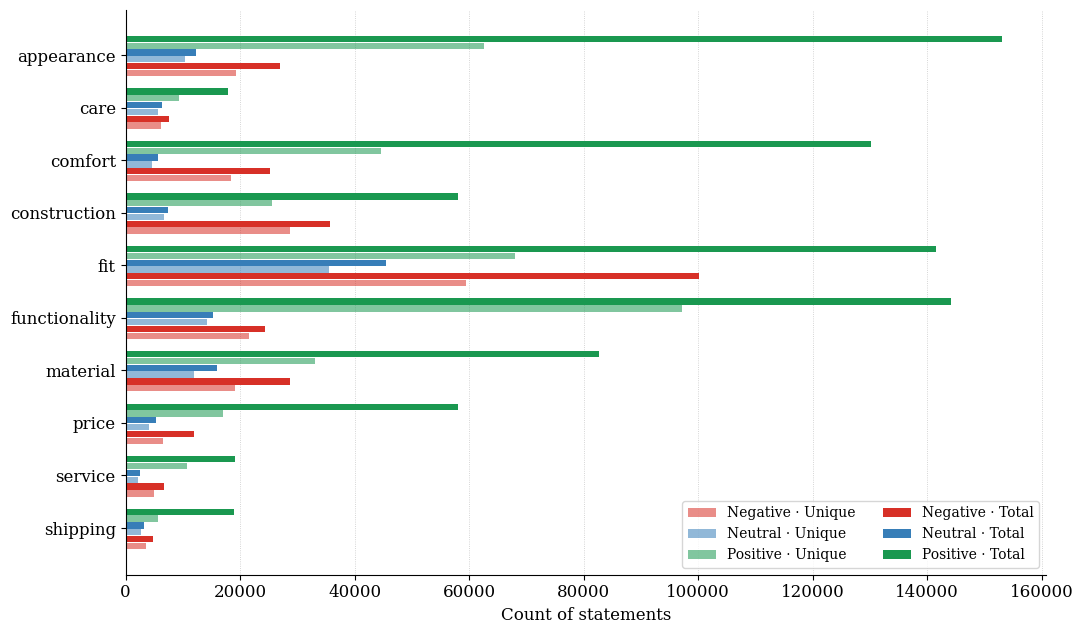

In [34]:
os.makedirs("plots", exist_ok=True)
plot_topic_sentiment_bars(
    final_correct_triplets_df_stats, 
    os.path.join("plots", dataset_name + "_topic_sentiment_statement_distribution.pdf")
)

In [35]:
new_data_df.to_csv(os.path.join(dataset_dir, "processed_dataset.csv"))

In [36]:
all_statements = []
all_topics = []
all_sentiments = []
all_freq = []

for i, ((statement, topic, sent), id_freq) in enumerate(all_triplets.items()):
    freq = id_freq["freq"]
    all_statements.append(statement)
    all_topics.append(topic)
    all_sentiments.append(sent)
    all_freq.append(freq)
    if i % 10_000 == 0:
        print((statement, topic, sent), freq)

statement_topic_sentiment_freq_df = pd.DataFrame({
    "statement": all_statements,
    "topic": all_topics,
    "sentiment": all_sentiments,
    "frequency": all_freq
})

print(len(statement_topic_sentiment_freq_df))

('has a low price relative to expectations', 'price', 'positive') 998
('offers good value for price and quality', 'price', 'positive') 1
('has a tag label, not sewn', 'care', 'neutral') 1
('may not provide adequate coverage for some body types', 'appearance', 'negative') 1
('fits a little large in the waist', 'fit', 'negative') 2
('price is reasonable but not exceptional', 'price', 'neutral') 1
('breaks in well', 'comfort', 'positive') 5
("does not fit reviewer's foot size", 'fit', 'negative') 1
('has long battery life', 'functionality', 'positive') 2
('blocks sunlight effectively', 'functionality', 'positive') 3
('ships quickly and free to apo', 'shipping', 'positive') 1
('has caused blisters on feet due to rubbing', 'comfort', 'negative') 1
('wrist size is slightly smaller than 8 inches', 'fit', 'neutral') 1
('does not exaggerate cleavage', 'appearance', 'positive') 1
('requires a specific width of 1/8 inch', 'fit', 'positive') 1
('may require a smaller band size', 'fit', 'negative')

('is a cheaper alternative to expensive hunter boots', 'price', 'positive') 1
("it's essential to have a good fitting bra to avoid discomfort", 'fit', 'positive') 1
('suspects frequent wear and tear', 'fit', 'neutral') 1
('straps on the sides are too large', 'fit', 'negative') 1
('will likely improve with wear', 'comfort', 'positive') 1
('does what it is intended for', 'functionality', 'positive') 1
("can be used to polish shoes to a level that meets captain's inspection standards", 'functionality', 'positive') 1
('can be pulled down around the neck', 'functionality', 'positive') 1
('recipient has recommended it to others', 'service', 'positive') 1
('feels like being wrapped in a towel', 'comfort', 'positive') 1
('has playful design element', 'appearance', 'positive') 1
('has a comfortable fit in terms of length', 'fit', 'positive') 1
('is suitable for working out on an elliptical', 'functionality', 'positive') 1
('lacks adjustability', 'fit', 'negative') 2
('package is still missing a

('does not look short', 'appearance', 'positive') 1
('accentuate the figure', 'fit', 'positive') 1
('makes the wearer feel cute', 'comfort', 'positive') 2
('has a purple and luscious appearance', 'appearance', 'positive') 1
('arrived with a running battery', 'care', 'negative') 1
('is more comfortable than wearing socks', 'comfort', 'positive') 1
('sizing is generous and comfortable', 'fit', 'positive') 1
('company does not stock shirts at amazon', 'shipping', 'negative') 1
('has a good price range', 'price', 'positive') 1
('has a perfect fit in size 9m', 'fit', 'positive') 1
('fabric is not suitable for those seeking denim like leggings', 'material', 'negative') 1
('is made of thin, sheer material', 'material', 'negative') 1
('backs fit properly', 'fit', 'neutral') 1
('crosses fell off after wear', 'construction', 'negative') 1
('has a wider bottom hem', 'appearance', 'negative') 1
('may require a white top under it', 'functionality', 'neutral') 1


659630


In [37]:
print(statement_topic_sentiment_freq_df.sample(n=10))

                                          statement          topic sentiment  \
164836                    can be used as a gift bag  functionality   neutral   
553399  may not be suitable for very slender wrists            fit   neutral   
422200          is difficult to read the clock face  functionality  negative   
306229                toes are mashed into the shoe        comfort  negative   
512768                  keeps cards and photos safe  functionality  positive   
569120                breaks zipper after short use   construction  negative   
659556     provide grip similar to hospital footies  functionality  positive   
55207               does not have good arch support        comfort  negative   
8201               may be second hand or mislabeled       material  negative   
191586             helps eliminate odors from boots  functionality  positive   

        frequency  
164836          1  
553399          1  
422200          1  
306229          1  
512768          1  

In [38]:
statement_topic_sentiment_freq_df.to_csv(os.path.join(dataset_dir, "statement_topic_sentiment_freq.csv"))

In [39]:
def analyze_statements_dataset(df):
    print("=" * 80)
    print("STATEMENT DATASET STATISTICAL ANALYSIS")
    print("=" * 80)
    
    # General statistics
    print("\nGENERAL STATISTICS")
    print("-" * 40)
    n_users = df['user_id'].nunique()
    n_items = df['item_id'].nunique()
    n_interactions = len(df)
    
    print(f"Unique users: {n_users:,}")
    print(f"Unique items: {n_items:,}")
    print(f"Total interactions: {n_interactions:,}")
    
    # Expand statements for analysis
    expanded_data = []
    for idx, row in df.iterrows():
        user_id = row['user_id']
        item_id = row['item_id']
        statements = row['statements']
        
        if isinstance(statements, list):
            for stmt_dict in statements:
                if isinstance(stmt_dict, dict):
                    expanded_data.append({
                        'user_id': user_id,
                        'item_id': item_id,
                        'interaction_id': idx,
                        'statement': stmt_dict.get('statement', ''),
                        'topic': stmt_dict.get('topic', ''),
                        'sentiment': stmt_dict.get('sentiment', '')
                    })
    
    expanded_df = pd.DataFrame(expanded_data)
    
    if expanded_df.empty:
        print("No valid statements found in the dataset")
        return
    
    print(f"Total statements: {len(expanded_df):,}")
    print(f"Unique statements: {expanded_df['statement'].nunique():,}")
    
    # Get unique sentiments and topics
    sentiments = sorted(expanded_df['sentiment'].unique())
    topics = sorted(expanded_df['topic'].unique())
    
    print(f"Sentiments: {sentiments}")
    print(f"Topics ({len(topics)}): {topics}")
    
    # Function to calculate statistics
    def calculate_stats(data, group_by, count_by='statement', unique=True):
        if unique:
            # Count unique statements
            stats = data.groupby(group_by)[count_by].nunique()
        else:
            # Count with frequency (all statements)
            stats = data.groupby(group_by)[count_by].count()
        
        return {
            'average': stats.mean(),
            'maximum': stats.max(),
            'minimum': stats.min(),
            'median': stats.median(),
            'std': stats.std()
        }
    
    # 1. USER STATISTICS
    print("\n" + "=" * 80)
    print("USER STATISTICS")
    print("=" * 80)
    
    user_stats_results = []
    
    # Global (all sentiments)
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, 'user_id', unique=unique)
        user_stats_results.append({
            'Metric': f'Statements per user ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # By sentiment
    for sentiment in sentiments:
        sentiment_data = expanded_df[expanded_df['sentiment'] == sentiment]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not sentiment_data.empty:
                stats = calculate_stats(sentiment_data, 'user_id', unique=unique)
                user_stats_results.append({
                    'Metric': f'Statements per user ({label})',
                    'Sentiment': sentiment,
                    'Topic': 'All',
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    # Per user/topic
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, ['user_id', 'topic'], unique=unique)
        user_stats_results.append({
            'Metric': f'Statements per user/topic ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # Per topic/user
    for topic in topics:
        topic_data = expanded_df[expanded_df['topic'] == topic]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not topic_data.empty:
                stats = calculate_stats(topic_data, 'user_id', unique=unique)
                user_stats_results.append({
                    'Metric': f'Statements per user for topic "{topic}" ({label})',
                    'Sentiment': 'All',
                    'Topic': topic,
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    user_stats_df = pd.DataFrame(user_stats_results)
    print(user_stats_df.to_string(index=False))
    
    # 2. ITEM STATISTICS
    print("\n" + "=" * 80)
    print("ITEM STATISTICS")
    print("=" * 80)
    
    item_stats_results = []
    
    # Global (all sentiments)
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, 'item_id', unique=unique)
        item_stats_results.append({
            'Metric': f'Statements per item ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # By sentiment
    for sentiment in sentiments:
        sentiment_data = expanded_df[expanded_df['sentiment'] == sentiment]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not sentiment_data.empty:
                stats = calculate_stats(sentiment_data, 'item_id', unique=unique)
                item_stats_results.append({
                    'Metric': f'Statements per item ({label})',
                    'Sentiment': sentiment,
                    'Topic': 'All',
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    # Per item/topic
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, ['item_id', 'topic'], unique=unique)
        item_stats_results.append({
            'Metric': f'Statements per item/topic ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # Per topic/item
    for topic in topics:
        topic_data = expanded_df[expanded_df['topic'] == topic]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not topic_data.empty:
                stats = calculate_stats(topic_data, 'item_id', unique=unique)
                item_stats_results.append({
                    'Metric': f'Statements per item for topic "{topic}" ({label})',
                    'Sentiment': 'All',
                    'Topic': topic,
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    item_stats_df = pd.DataFrame(item_stats_results)
    print(item_stats_df.to_string(index=False))
    
    # 3. INTERACTION STATISTICS
    print("\n" + "=" * 80)
    print("INTERACTION STATISTICS")
    print("=" * 80)
    
    interaction_stats_results = []
    
    # Global (all sentiments)
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, 'interaction_id', unique=unique)
        interaction_stats_results.append({
            'Metric': f'Statements per interaction ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # By sentiment
    for sentiment in sentiments:
        sentiment_data = expanded_df[expanded_df['sentiment'] == sentiment]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not sentiment_data.empty:
                stats = calculate_stats(sentiment_data, 'interaction_id', unique=unique)
                interaction_stats_results.append({
                    'Metric': f'Statements per interaction ({label})',
                    'Sentiment': sentiment,
                    'Topic': 'All',
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    # Per interaction/topic
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, ['interaction_id', 'topic'], unique=unique)
        interaction_stats_results.append({
            'Metric': f'Statements per interaction/topic ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # Per topic/interaction
    for topic in topics:
        topic_data = expanded_df[expanded_df['topic'] == topic]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not topic_data.empty:
                stats = calculate_stats(topic_data, 'interaction_id', unique=unique)
                interaction_stats_results.append({
                    'Metric': f'Statements per interaction for topic "{topic}" ({label})',
                    'Sentiment': 'All',
                    'Topic': topic,
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    interaction_stats_df = pd.DataFrame(interaction_stats_results)
    print(interaction_stats_df.to_string(index=False))
    
    # 4. SENTIMENT AND TOPIC DISTRIBUTION
    print("\n" + "=" * 80)
    print("SENTIMENT AND TOPIC DISTRIBUTION")
    print("=" * 80)
    
    # Sentiment distribution
    sentiment_counts = expanded_df['sentiment'].value_counts()
    sentiment_unique_counts = expanded_df.groupby('sentiment')['statement'].nunique()
    
    sentiment_dist = pd.DataFrame({
        'Sentiment': sentiment_counts.index,
        'Total_Count': sentiment_counts.values,
        'Unique_Count': [sentiment_unique_counts.get(s, 0) for s in sentiment_counts.index],
        'Total_Percentage': (sentiment_counts.values / len(expanded_df) * 100),
        'Unique_Percentage': (sentiment_unique_counts.values / expanded_df['statement'].nunique() * 100)
    })
    
    print("Sentiment distribution:")
    print(sentiment_dist.round(2).to_string(index=False))
    
    # Topic distribution
    topic_counts = expanded_df['topic'].value_counts()
    topic_unique_counts = expanded_df.groupby('topic')['statement'].nunique()
    
    topic_dist = pd.DataFrame({
        'Topic': topic_counts.index,
        'Total_Count': topic_counts.values,
        'Unique_Count': [topic_unique_counts.get(t, 0) for t in topic_counts.index],
        'Total_Percentage': (topic_counts.values / len(expanded_df) * 100),
        'Unique_Percentage': (topic_unique_counts.values / expanded_df['statement'].nunique() * 100)
    })
    
    print("\nTopic distribution:")
    print(topic_dist.round(2).to_string(index=False))
    
    # 5. SENTIMENT x TOPIC CROSS-MATRIX
    print("\n" + "=" * 80)
    print("SENTIMENT x TOPIC CROSS-MATRIX")
    print("=" * 80)
    
    # With frequency
    cross_matrix_freq = pd.crosstab(expanded_df['sentiment'], expanded_df['topic'], margins=True)
    print("Matrix with frequency:")
    print(cross_matrix_freq)
    
    # Unique statements
    cross_matrix_unique = pd.crosstab(expanded_df['sentiment'], expanded_df['topic'], 
                                    values=expanded_df['statement'], aggfunc='nunique', margins=True)
    print("\nMatrix with unique statements:")
    print(cross_matrix_unique.fillna(0).astype(int))
    
    # 6. COMPREHENSIVE STATISTICS SUMMARY
    print("\n" + "=" * 80)
    print("COMPREHENSIVE STATISTICS SUMMARY")
    print("=" * 80)
    
    # Create a comprehensive summary DataFrame
    summary_stats = []
    
    # Helper function to add stats
    def add_stats(group_type, group_cols, sentiment_filter=None, topic_filter=None):
        data = expanded_df.copy()
        
        if sentiment_filter:
            data = data[data['sentiment'] == sentiment_filter]
        if topic_filter:
            data = data[data['topic'] == topic_filter]
        
        if data.empty:
            return
        
        for unique in [True, False]:
            count_type = "Unique" if unique else "Frequency"
            
            if unique:
                grouped = data.groupby(group_cols)['statement'].nunique()
            else:
                grouped = data.groupby(group_cols)['statement'].count()
            
            summary_stats.append({
                'Grouping': group_type,
                'Sentiment': sentiment_filter or 'All',
                'Topic': topic_filter or 'All',
                'Count_Type': count_type,
                'Average': round(grouped.mean(), 2),
                'Maximum': int(grouped.max()),
                'Minimum': int(grouped.min()),
                'Median': round(grouped.median(), 2),
                'Std_Dev': round(grouped.std(), 2)
            })
    
    # Add all combinations
    add_stats('Per user', ['user_id'])
    add_stats('Per user/topic', ['user_id', 'topic'])
    add_stats('Per item', ['item_id'])
    add_stats('Per item/topic', ['item_id', 'topic'])
    add_stats('Per interaction', ['interaction_id'])
    add_stats('Per interaction/topic', ['interaction_id', 'topic'])
    
    # By sentiment
    for sentiment in sentiments:
        add_stats('Per user', ['user_id'], sentiment_filter=sentiment)
        add_stats('Per item', ['item_id'], sentiment_filter=sentiment)
        add_stats('Per interaction', ['interaction_id'], sentiment_filter=sentiment)

    for topic in topics:
        add_stats('Per user', ['user_id'], topic_filter=topic)
        add_stats('Per item', ['item_id'], topic_filter=topic)
        add_stats('Per interaction', ['interaction_id'], topic_filter=topic)
    
    summary_df = pd.DataFrame(summary_stats)
    print("Comprehensive statistics summary:")
    print(summary_df.to_string(index=False))
    
    # 7. TOP CONTRIBUTORS
    print("\n" + "=" * 80)
    print("TOP CONTRIBUTORS")
    print("=" * 80)
    
    # Top users
    top_users_freq = expanded_df.groupby('user_id')['statement'].count().nlargest(5)
    top_users_unique = expanded_df.groupby('user_id')['statement'].nunique().nlargest(5)
    
    print("Top 5 users (by statement frequency):")
    for user_id, count in top_users_freq.items():
        print(f"  {user_id}: {count} statements")
    
    print("\nTop 5 users (by unique statements):")
    for user_id, count in top_users_unique.items():
        print(f"  {user_id}: {count} unique statements")
    
    # Top items
    top_items_freq = expanded_df.groupby('item_id')['statement'].count().nlargest(5)
    top_items_unique = expanded_df.groupby('item_id')['statement'].nunique().nlargest(5)
    
    print("\nTop 5 items (by statement frequency):")
    for item_id, count in top_items_freq.items():
        print(f"  {item_id}: {count} statements")
    
    print("\nTop 5 items (by unique statements):")
    for item_id, count in top_items_unique.items():
        print(f"  {item_id}: {count} unique statements")
    
    # 8. DIVERSITY STATISTICS
    print("\n" + "=" * 80)
    print("DIVERSITY STATISTICS")
    print("=" * 80)
    
    diversity_stats = []
    
    # Diversity per user (number of different topics)
    user_topic_diversity = expanded_df.groupby('user_id')['topic'].nunique()
    diversity_stats.append({
        'Metric': 'Topics per user',
        'Average': round(user_topic_diversity.mean(), 2),
        'Maximum': int(user_topic_diversity.max()),
        'Minimum': int(user_topic_diversity.min()),
        'Median': round(user_topic_diversity.median(), 2)
    })
    
    # Diversity per user (number of different sentiments)
    user_sentiment_diversity = expanded_df.groupby('user_id')['sentiment'].nunique()
    diversity_stats.append({
        'Metric': 'Sentiments per user',
        'Average': round(user_sentiment_diversity.mean(), 2),
        'Maximum': int(user_sentiment_diversity.max()),
        'Minimum': int(user_sentiment_diversity.min()),
        'Median': round(user_sentiment_diversity.median(), 2)
    })
    
    # Diversity per item
    item_topic_diversity = expanded_df.groupby('item_id')['topic'].nunique()
    diversity_stats.append({
        'Metric': 'Topics per item',
        'Average': round(item_topic_diversity.mean(), 2),
        'Maximum': int(item_topic_diversity.max()),
        'Minimum': int(item_topic_diversity.min()),
        'Median': round(item_topic_diversity.median(), 2)
    })
    
    item_sentiment_diversity = expanded_df.groupby('item_id')['sentiment'].nunique()
    diversity_stats.append({
        'Metric': 'Sentiments per item',
        'Average': round(item_sentiment_diversity.mean(), 2),
        'Maximum': int(item_sentiment_diversity.max()),
        'Minimum': int(item_sentiment_diversity.min()),
        'Median': round(item_sentiment_diversity.median(), 2)
    })
    
    diversity_df = pd.DataFrame(diversity_stats)
    print("Diversity statistics:")
    print(diversity_df.to_string(index=False))
    
    # 9. STATEMENT FREQUENCY ANALYSIS
    print("\n" + "=" * 80)
    print("STATEMENT FREQUENCY ANALYSIS")
    print("=" * 80)
    
    # Most frequent statements
    statement_freq = expanded_df['statement'].value_counts()
    print("Top 10 most frequent statements:")
    for i, (stmt, count) in enumerate(statement_freq.head(10).items(), 1):
        print(f"  {i:2d}. '{stmt[:50]}{'...' if len(stmt) > 50 else ''}' (count: {count})")
    
    # Statement length statistics
    expanded_df['statement_length'] = expanded_df['statement'].str.len()
    length_stats = expanded_df['statement_length'].describe()
    
    print(f"\nStatement length statistics:")
    print(f"  Average length: {length_stats['mean']:.1f} characters")
    print(f"  Maximum length: {length_stats['max']:.0f} characters")
    print(f"  Minimum length: {length_stats['min']:.0f} characters")
    print(f"  Median length: {length_stats['50%']:.1f} characters")
    
    print("\n" + "=" * 80)
    print("ANALYSIS COMPLETED")

In [40]:
analyze_statements_dataset(new_data_df)

STATEMENT DATASET STATISTICAL ANALYSIS

GENERAL STATISTICS
----------------------------------------
Unique users: 39,385
Unique items: 23,033
Total interactions: 274,774


Total statements: 1,215,270


Unique statements: 619,917


Sentiments: ['negative', 'neutral', 'positive']
Topics (10): ['appearance', 'care', 'comfort', 'construction', 'fit', 'functionality', 'material', 'price', 'service', 'shipping']

USER STATISTICS


                                                        Metric Sentiment         Topic Average Maximum Minimum Median Std_Dev
                                  Statements per user (Unique)       All           All   30.12     541       1  25.00   20.25
                          Statements per user (With frequency)       All           All   30.86     560       1  26.00   21.10
                                  Statements per user (Unique)  negative           All    7.48     161       1   6.00    6.52
                          Statements per user (With frequency)  negative           All    7.52     161       1   6.00    6.58
                                  Statements per user (Unique)   neutral           All    3.73      82       1   3.00    3.57
                          Statements per user (With frequency)   neutral           All    3.74      83       1   3.00    3.59
                                  Statements per user (Unique)  positive           All   20.25     398       1  17.00 

                                                        Metric Sentiment         Topic Average Maximum Minimum Median Std_Dev
                                  Statements per item (Unique)       All           All   50.70    1178       4  34.00   54.39
                          Statements per item (With frequency)       All           All   52.76    1572       4  35.00   60.79
                                  Statements per item (Unique)  negative           All   12.08     309       1   8.00   14.78
                          Statements per item (With frequency)  negative           All   12.20     340       1   8.00   15.28
                                  Statements per item (Unique)   neutral           All    5.69     159       1   4.00    6.93
                          Statements per item (With frequency)   neutral           All    5.70     170       1   4.00    7.02
                                  Statements per item (Unique)  positive           All   33.91     763       1  23.00 

                                                               Metric Sentiment         Topic Average Maximum Minimum Median Std_Dev
                                  Statements per interaction (Unique)       All           All    4.42      21       1   4.00    2.21
                          Statements per interaction (With frequency)       All           All    4.42      21       1   4.00    2.22
                                  Statements per interaction (Unique)  negative           All    2.18      15       1   2.00    1.36
                          Statements per interaction (With frequency)  negative           All    2.18      15       1   2.00    1.36
                                  Statements per interaction (Unique)   neutral           All    1.48      15       1   1.00    0.87
                          Statements per interaction (With frequency)   neutral           All    1.48      15       1   1.00    0.87
                                  Statements per interaction (Unique)

Sentiment distribution:
Sentiment  Total_Count  Unique_Count  Total_Percentage  Unique_Percentage
 positive       823652        356445             67.78              29.47
 negative       272280        182671             22.40              15.44
  neutral       119338         95722              9.82              57.50



Topic distribution:
        Topic  Total_Count  Unique_Count  Total_Percentage  Unique_Percentage
          fit       287263        157658             23.64              14.56
   appearance       192384         90272             15.83               3.36
functionality       183724        131402             15.12              10.80
      comfort       161015         66941             13.25               9.73
     material       127305         61853             10.48              25.43
 construction       101113         60323              8.32              21.20
        price        75252         26910              6.19               9.98
         care        31947         20817              2.63               4.34
      service        28255         17756              2.32               2.86
     shipping        27012         11639              2.22               1.88

SENTIMENT x TOPIC CROSS-MATRIX


Matrix with frequency:
topic      appearance   care  comfort  construction     fit  functionality  \
sentiment                                                                    
negative        27012   7649    25254         35683  100201          24397   
neutral         12266   6430     5625          7380   45489          15193   
positive       153106  17868   130136         58050  141573         144134   
All            192384  31947   161015        101113  287263         183724   

topic      material  price  service  shipping      All  
sentiment                                               
negative      28719  11895     6636      4834   272280  
neutral       15967   5306     2466      3216   119338  
positive      82619  58051    19153     18962   823652  
All          127305  75252    28255     27012  1215270  



Matrix with unique statements:
topic      appearance   care  comfort  construction     fit  functionality  \
sentiment                                                                    
negative        19294   6266    18424         28740   59530          21519   
neutral         10325   5589     4636          6686   35603          14166   
positive        62620   9411    44530         25558   68037          97147   
All             90272  20817    66941         60323  157658         131402   

topic      material  price  service  shipping     All  
sentiment                                              
negative      19044   6599     4993      3600  182671  
neutral       11905   4051     2239      2697   95722  
positive      33158  16943    10680      5640  356445  
All           61853  26910    17756     11639  619917  

COMPREHENSIVE STATISTICS SUMMARY


Comprehensive statistics summary:
             Grouping Sentiment         Topic Count_Type  Average  Maximum  Minimum  Median  Std_Dev
             Per user       All           All     Unique    30.12      541        1    25.0    20.25
             Per user       All           All  Frequency    30.86      560        1    26.0    21.10
       Per user/topic       All           All     Unique     4.12      141        1     3.0     4.10
       Per user/topic       All           All  Frequency     4.21      148        1     3.0     4.23
             Per item       All           All     Unique    50.70     1178        4    34.0    54.39
             Per item       All           All  Frequency    52.76     1572        4    35.0    60.79
       Per item/topic       All           All     Unique     6.34      409        1     4.0     9.60
       Per item/topic       All           All  Frequency     6.58      471        1     4.0    10.58
      Per interaction       All           All     Unique 

Top 5 users (by statement frequency):
  A2GA55P7WGHJCP: 560 statements
  AWBGHDHH7E51F: 528 statements
  A2J4XMWKR8PPD0: 514 statements
  A2KBV88FL48CFS: 453 statements
  AENH50GW3OKDA: 452 statements

Top 5 users (by unique statements):
  A2GA55P7WGHJCP: 541 unique statements
  AWBGHDHH7E51F: 520 unique statements
  A2J4XMWKR8PPD0: 430 unique statements
  A2V5R832QCSOMX: 400 unique statements
  AENH50GW3OKDA: 400 unique statements



Top 5 items (by statement frequency):
  B005LERHD8: 1572 statements
  B005GYGD7O: 1178 statements
  B008WYDP1C: 1111 statements
  B0058XIMMM: 1102 statements
  B0001ZNZJM: 1011 statements

Top 5 items (by unique statements):
  B005LERHD8: 1178 unique statements
  B005GYGD7O: 980 unique statements
  B008WYDP1C: 945 unique statements
  B0058XIMMM: 878 unique statements
  B0001ZNZJM: 867 unique statements

DIVERSITY STATISTICS


Diversity statistics:
             Metric  Average  Maximum  Minimum  Median
    Topics per user     7.32       10        1     7.0
Sentiments per user     2.73        3        1     3.0
    Topics per item     8.02       10        2     8.0
Sentiments per item     2.88        3        1     3.0

STATEMENT FREQUENCY ANALYSIS
Top 10 most frequent statements:
   1. 'is comfortable to wear' (count: 15972)
   2. 'fits well' (count: 12580)
   3. 'is comfortable' (count: 6087)
   4. 'is well made' (count: 5467)
   5. 'are comfortable' (count: 5121)
   6. 'are comfortable to wear' (count: 4380)
   7. 'fits perfectly' (count: 3536)
   8. 'has a good fit' (count: 3337)
   9. 'is lightweight' (count: 3336)
  10. 'has good quality' (count: 3199)



Statement length statistics:
  Average length: 27.4 characters
  Maximum length: 160 characters
  Minimum length: 3 characters
  Median length: 25.0 characters

ANALYSIS COMPLETED
